# 4.7 Classification

## 4.7.1 The Stock Market Data

In [79]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
                        summarize)

In [80]:
from ISLP import confusion_table
from ISLP.models import contrast
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis as LDA,
                                           QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [81]:
Smarket = load_data("Smarket")
Smarket

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.19130,0.959,Up
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.29650,1.032,Up
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.41120,-0.623,Down
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.27600,0.614,Up
4,2001,0.614,-0.623,1.032,0.959,0.381,1.20570,0.213,Up
...,...,...,...,...,...,...,...,...,...
1245,2005,0.422,0.252,-0.024,-0.584,-0.285,1.88850,0.043,Up
1246,2005,0.043,0.422,0.252,-0.024,-0.584,1.28581,-0.955,Down
1247,2005,-0.955,0.043,0.422,0.252,-0.024,1.54047,0.130,Up
1248,2005,0.130,-0.955,0.043,0.422,0.252,1.42236,-0.298,Down


In [82]:
Smarket.columns

Index(['Year', 'Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume', 'Today',
       'Direction'],
      dtype='object')

In [83]:
Smarket.corr()

/tmp/ipykernel_10098/1907124636.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Smarket.corr()


,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.000000,0.029700,0.030596,0.033195,0.035689,0.029788,0.539006,0.030095
Lag1,0.029700,1.000000,-0.026294,-0.010803,-0.002986,-0.005675,0.040910,-0.026155
Lag2,0.030596,-0.026294,1.000000,-0.025897,-0.010854,-0.003558,-0.043383,-0.010250
Lag3,0.033195,-0.010803,-0.025897,1.000000,-0.024051,-0.018808,-0.041824,-0.002448
Lag4,0.035689,-0.002986,-0.010854,-0.024051,1.000000,-0.027084,-0.048414,-0.006900
Lag5,0.029788,-0.005675,-0.003558,-0.018808,-0.027084,1.000000,-0.022002,-0.034860
Volume,0.539006,0.040910,-0.043383,-0.041824,-0.048414,-0.022002,1.000000,0.014592
Today,0.030095,-0.026155,-0.010250,-0.002448,-0.006900,-0.034860,0.014592,1.000000


## 4.7.2 Logistic Regression

The `sm.GLM()` function fits generalized linear models, a class of models that includes logistic regression. Alternatively, the function `sm.Logit()` fits a logistic regression directly.

In [84]:
allvars = Smarket.columns.drop(["Today", "Direction", "Year"])
design = MS(allvars)
X = design.fit_transform(Smarket)
y = Smarket.Direction == "Up"
glm = sm.GLM(y,
             X,
             family=sm.families.Binomial())
results = glm.fit()
summarize(results)

,coef,std err,z,P>|z|
intercept,-0.1260,0.241,-0.523,0.601
Lag1,-0.0731,0.050,-1.457,0.145
Lag2,-0.0423,0.050,-0.845,0.398
Lag3,0.0111,0.050,0.222,0.824
Lag4,0.0094,0.050,0.187,0.851
Lag5,0.0103,0.050,0.208,0.835
Volume,0.1354,0.158,0.855,0.392


In [85]:
results.params

intercept   -0.126000
Lag1        -0.073074
Lag2        -0.042301
Lag3         0.011085
Lag4         0.009359
Lag5         0.010313
Volume       0.135441
dtype: float64

In [86]:
results.pvalues

intercept    0.600700
Lag1         0.145232
Lag2         0.398352
Lag3         0.824334
Lag4         0.851445
Lag5         0.834998
Volume       0.392404
dtype: float64

In [87]:
probs = results.predict() # This predicts on the entire train dataset
probs[:10]

array([0.50708413, 0.48146788, 0.48113883, 0.51522236, 0.51078116,
       0.50695646, 0.49265087, 0.50922916, 0.51761353, 0.48883778])

In [88]:
labels = np.array(["Down"] * 1250)
labels[probs > 0.5] = "Up"

In [89]:
confusion_table(labels, Smarket.Direction)

Truth,Down,Up
Predicted,,
Down,145,141
Up,457,507


In [90]:
np.mean(labels == Smarket.Direction)

0.5216

Note this error rate of 100 - 52.16 is the train error rate. But we are interested in the test error rate.

In [91]:
train = (Smarket.Year < 2005)
Smarket_train = Smarket.loc[train]
Smarket_test = Smarket.loc[~train]

In [92]:
Smarket_test.shape

(252, 9)

In [93]:
X_train, X_test = X.loc[train], X.loc[~train]
y_train, y_test = y.loc[train], y.loc[~train]
glm_train = sm.GLM(y_train, X_train, family=sm.families.Binomial())
results = glm_train.fit()
probs = results.predict(exog=X_test)

In [94]:
D = Smarket.Direction
L_train, L_test = D.loc[train], D.loc[~train]

In [95]:
labels = np.array(["Down"] * 252)
labels[probs>0.5] = "Up"
confusion_table(labels, L_test)

Truth,Down,Up
Predicted,,
Down,77,97
Up,34,44


In [96]:
np.mean(labels == L_test)

0.4801587301587302

### Using Only Two Variables

In [97]:
model = MS(["Lag1", "Lag2"]).fit(Smarket)
X = model.transform(Smarket)
X_train, X_test = X.loc[train], X.loc[~train]
glm_train = sm.GLM(y_train,
                   X_train,
                   family=sm.families.Binomial())
results = glm_train.fit()

In [98]:
probs = results.predict(exog=X_test)
labels = np.array(["Down"] * 252)
labels[probs > 0.5] = "Up"
confusion_table(labels, L_test)

Truth,Down,Up
Predicted,,
Down,35,35
Up,76,106


In [99]:
np.mean(labels == L_test)

0.5595238095238095

In [100]:
new_data = pd.DataFrame({"Lag1": [1.2, 1.5],
                         "Lag2": [1.1, -0.8]})

In [101]:
new_X = model.transform(new_data)
results.predict(new_X)

0    0.479146
1    0.496094
dtype: float64

## 4.7.3 Linear Discriminant Analysis

In [102]:
lda = LDA(store_covariance=True)

In [103]:
X_train, X_test = [M.drop(columns=["intercept"]) for M in [X_train, X_test]]
lda.fit(X_train, L_train)

LinearDiscriminantAnalysis(store_covariance=True)

In [104]:
lda.means_

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

In [105]:
lda.classes_

array(['Down', 'Up'], dtype='<U4')

In [106]:
lda.priors_

array([0.49198397, 0.50801603])

In [107]:
lda.scalings_

array([[-0.64201904],
       [-0.51352928]])

In [108]:
lda_pred = lda.predict(X_test)

In [109]:
confusion_table(lda_pred, L_test)

Truth,Down,Up
Predicted,,
Down,35,35
Up,76,106


In [110]:
lda_prob = lda.predict_proba(X_test)
lda_prob

array([[0.49017925, 0.50982075],
       [0.4792185 , 0.5207815 ],
       [0.46681848, 0.53318152],
       [0.47400107, 0.52599893],
       [0.49278766, 0.50721234],
       [0.49385615, 0.50614385],
       [0.49510156, 0.50489844],
       [0.4872861 , 0.5127139 ],
       [0.49070135, 0.50929865],
       [0.48440262, 0.51559738],
       [0.49069628, 0.50930372],
       [0.51199885, 0.48800115],
       [0.48951523, 0.51048477],
       [0.47067612, 0.52932388],
       [0.47445929, 0.52554071],
       [0.47995834, 0.52004166],
       [0.49357753, 0.50642247],
       [0.50308938, 0.49691062],
       [0.49788061, 0.50211939],
       [0.48863309, 0.51136691],
       [0.50065681, 0.49934319],
       [0.51087353, 0.48912647],
       [0.50399248, 0.49600752],
       [0.49163351, 0.50836649],
       [0.50417721, 0.49582279],
       [0.50267505, 0.49732495],
       [0.49140429, 0.50859571],
       [0.48059641, 0.51940359],
       [0.48827181, 0.51172819],
       [0.50621869, 0.49378131],
       [0.

In [111]:
np.all(
    np.where(lda_prob[:, 1] >= 0.5, "Up", "Down") == lda_pred
)

True

In [112]:
np.all(
    [lda.classes_[i] for i in np.argmax(lda_prob, 1)] == lda_pred
)

True

### Using a threshold other than `50%` for LDA

In [113]:
np.sum(lda_prob[:, 0] > 0.9)

0

## 4.7.4 Quadratic Discriminant Analysis

In [114]:
qda = QDA(store_covariance=True)
qda.fit(X_train, L_train)

QuadraticDiscriminantAnalysis(store_covariance=True)

In [115]:
qda.means_, qda.priors_

(array([[ 0.04279022,  0.03389409],
        [-0.03954635, -0.03132544]]),
 array([0.49198397, 0.50801603]))

In [116]:
qda.covariance_

[array([[ 1.50662277, -0.03924806],
        [-0.03924806,  1.53559498]]),
 array([[ 1.51700576, -0.02787349],
        [-0.02787349,  1.49026815]])]

In [117]:
qda_pred = qda.predict(X_test)
confusion_table(qda_pred, L_test)

Truth,Down,Up
Predicted,,
Down,30,20
Up,81,121


In [118]:
np.mean(qda_pred == L_test)

0.5992063492063492

## 4.7.5 Naive Bayes

In [119]:
NB = GaussianNB()
NB.fit(X_train, L_train)

GaussianNB()

In [120]:
NB.classes_

array(['Down', 'Up'], dtype='<U4')

In [121]:
NB.class_prior_

array([0.49198397, 0.50801603])

In [122]:
NB.theta_

array([[ 0.04279022,  0.03389409],
       [-0.03954635, -0.03132544]])

In [123]:
NB.var_

array([[1.50355429, 1.53246749],
       [1.51401364, 1.48732877]])

In [124]:
nb_labels = NB.predict(X_test)
confusion_table(nb_labels, L_test)

Truth,Down,Up
Predicted,,
Down,29,20
Up,82,121


In [125]:
np.mean(nb_labels == L_test)

0.5952380952380952

## 4.7.6 K-Nearest Neighbours

In [126]:
knn1 = KNeighborsClassifier(n_neighbors=1)
knn1.fit(X_train, L_train)
knn1_pred = knn1.predict(X_test)
confusion_table(knn1_pred, L_test)

Truth,Down,Up
Predicted,,
Down,43,58
Up,68,83


In [127]:
np.mean(knn1_pred == L_test)

0.5

In [128]:
knn3 = KNeighborsClassifier(n_neighbors=3)
knn3.fit(X_train, L_train)
knn3_pred = knn3.predict(X_test)
confusion_table(knn3_pred, L_test)

Truth,Down,Up
Predicted,,
Down,48,55
Up,63,86


In [129]:
np.mean(knn3_pred == L_test)

0.5317460317460317

In [130]:
Caravan = load_data("Caravan")
Purchase = Caravan.Purchase
Purchase.value_counts()

No     5474
Yes     348
Name: Purchase, dtype: int64

In [131]:
features_df = Caravan.drop(columns=["Purchase"])

Because the KNN classifier predicts the class of a given test observation by identifying the observations that are nearest to it, the scale of the variables matters.

In [132]:
scaler = StandardScaler()

In [133]:
scaler.fit(features_df)
X_std = scaler.transform(features_df)

In [134]:
features_std = pd.DataFrame(X_std,
                            columns=features_df.columns);
features_std.std()

MOSTYPE     1.000086
MAANTHUI    1.000086
MGEMOMV     1.000086
MGEMLEEF    1.000086
MOSHOOFD    1.000086
              ...   
AZEILPL     1.000086
APLEZIER    1.000086
AFIETS      1.000086
AINBOED     1.000086
ABYSTAND    1.000086
Length: 85, dtype: float64

In [135]:
(X_train, 
 X_test,
 y_train,
 y_test) = train_test_split(features_std,
                            Purchase,
                            test_size=1000,
                            random_state=0)

In [136]:
knn1 = KNeighborsClassifier(n_neighbors=1)
knn1_pred = knn1.fit(X_train, y_train).predict(X_test)
np.mean(y_test != knn1_pred), np.mean(y_test != "No")

(0.111, 0.067)

Since just over 6% of customers purchased insurance, we could get the error rate down to almost 6% by always predicting No regardless of the values of the predictors! This is known as the null rate.

In [137]:
confusion_table(knn1_pred, y_test)

Truth,No,Yes
Predicted,,
No,880,58
Yes,53,9


In [138]:
for k in range(1, 6):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn_pred = knn.fit(X_train, y_train).predict(X_test)
    C = confusion_table(knn_pred, y_test)
    templ = ('K={0:d}: # predicted to rent: {1:>2}, ' +
             ' # who did rent {2:d}, accuracy {3:.1%}')
    pred = C.loc["Yes"].sum()
    did_rent = C.loc["Yes", "Yes"]
    print(templ.format(k, pred, did_rent, did_rent/pred))

K=1: # predicted to rent: 62,  # who did rent 9, accuracy 14.5%
K=2: # predicted to rent:  6,  # who did rent 1, accuracy 16.7%
K=3: # predicted to rent: 20,  # who did rent 3, accuracy 15.0%
K=4: # predicted to rent:  4,  # who did rent 0, accuracy 0.0%
K=5: # predicted to rent:  7,  # who did rent 1, accuracy 14.3%


## 4.7.7 Linear and Poisson Regression on BikeShare Data

In [139]:
Bike = load_data("Bikeshare")

In [140]:
Bike.shape, Bike.columns

((8645, 15),
 Index(['season', 'mnth', 'day', 'hr', 'holiday', 'weekday', 'workingday',
        'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual',
        'registered', 'bikers'],
       dtype='object'))

In [141]:
X = MS(["mnth", 
        "hr",
        "workingday",
        "temp",
        "weathersit"]).fit_transform(Bike)
Y = Bike["bikers"]
M_lm = sm.OLS(Y, X).fit()
s1 = summarize(M_lm)

In [142]:
hr_encode = contrast("hr", "sum")
mnth_encode = contrast("mnth", "sum")

In [144]:
X2 = MS([mnth_encode, 
        hr_encode,
        "workingday",
        "temp",
        "weathersit"
        ]).fit_transform(Bike)
Y = Bike["bikers"]
M2_lm = sm.OLS(Y, X2).fit()
S2 = summarize(M2_lm)
S2

,coef,std err,t,P>|t|
intercept,73.5974,5.132,14.340,0.000
mnth[Jan],-46.0871,4.085,-11.281,0.000
mnth[Feb],-39.2419,3.539,-11.088,0.000
mnth[March],-29.5357,3.155,-9.361,0.000
mnth[April],-4.6622,2.741,-1.701,0.089
mnth[May],26.4700,2.851,9.285,0.000
mnth[June],21.7317,3.465,6.272,0.000
mnth[July],-0.7626,3.908,-0.195,0.845
mnth[Aug],7.1560,3.535,2.024,0.043
mnth[Sept],20.5912,3.046,6.761,0.000


In [145]:
coeff_mnth = S2[S2.index.str.contains("mnth")]["coef"]
coeff_mnth

mnth[Jan]     -46.0871
mnth[Feb]     -39.2419
mnth[March]   -29.5357
mnth[April]    -4.6622
mnth[May]      26.4700
mnth[June]     21.7317
mnth[July]     -0.7626
mnth[Aug]       7.1560
mnth[Sept]     20.5912
mnth[Oct]      29.7472
mnth[Nov]      14.2229
Name: coef, dtype: float64

In [157]:
months = Bike["mnth"].dtype.categories
coeff_mnth = pd.concat([
    coeff_mnth,
    pd.Series(-coeff_mnth.sum(),
              index=["mnth[Dec]"])
])
coeff_mnth

mnth[Jan]     -46.0871
mnth[Feb]     -39.2419
mnth[March]   -29.5357
mnth[April]    -4.6622
mnth[May]      26.4700
mnth[June]     21.7317
mnth[July]     -0.7626
mnth[Aug]       7.1560
mnth[Sept]     20.5912
mnth[Oct]      29.7472
mnth[Nov]      14.2229
mnth[Jan]       0.3705
mnth[Dec]      -0.0000
dtype: float64

Text(0, 0.5, 'Coefficient')

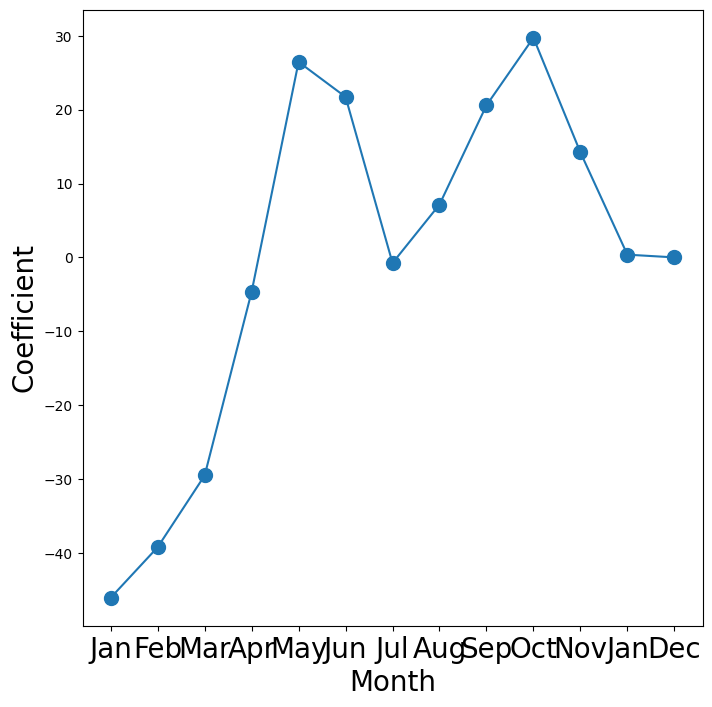

In [158]:
fig_month, ax_month = subplots(figsize=(8, 8))
x_month = np.arange(coeff_mnth.shape[0])
ax_month.plot(x_month, coeff_mnth, marker="o", ms=10)
ax_month.set_xticks(x_month)
ax_month.set_xticklabels([l[5:8] for l in coeff_mnth.index], fontsize=20)
ax_month.set_xlabel("Month", fontsize=20)
ax_month.set_ylabel("Coefficient", fontsize=20)

In [159]:
coeff_hr = S2[S2.index.str.contains("hr")]["coef"]
coeff_hr = coeff_hr.reindex(["hr[{0}]".format(h) for h in range(23)])
coeff_hr = pd.concat([coeff_hr,
                      pd.Series([-coeff_hr.sum()], index=["hr[23]"])])

Text(0, 0.5, 'Coefficient')

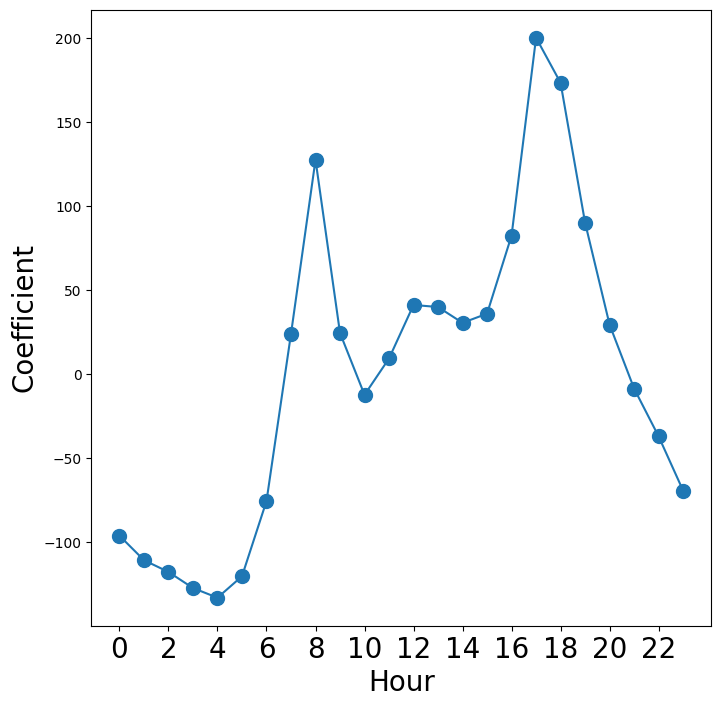

In [154]:
fig_hr, ax_hr = subplots(figsize=(8, 8))
x_hr = np.arange(coeff_hr.shape[0])
ax_hr.plot(x_hr, coeff_hr, marker="o", ms=10)
ax_hr.set_xticks(x_hr[::2])
ax_hr.set_xticklabels(range(24)[::2], fontsize=20)
ax_hr.set_xlabel("Hour", fontsize=20)
ax_hr.set_ylabel("Coefficient", fontsize=20)

### Poisson Regression

In [155]:
M_pois = sm.GLM(Y, X2, family=sm.families.Poisson()).fit()

In [156]:
S_pois = summarize(M_pois)

In [162]:
coeff_mnth = S_pois[S_pois.index.str.contains("mnth")]["coef"]
coeff_mnth = pd.concat([
    coeff_mnth,
    pd.Series(-coeff_mnth.sum(),
              index=["mnth[Dec]"])
])
coeff_hr = S_pois[S_pois.index.str.contains("hr")]["coef"]
coeff_hr = pd.concat([coeff_hr,
                      pd.Series([-coeff_hr.sum()], index=["hr[23]"])])

Text(0, 0.5, 'Coefficient')

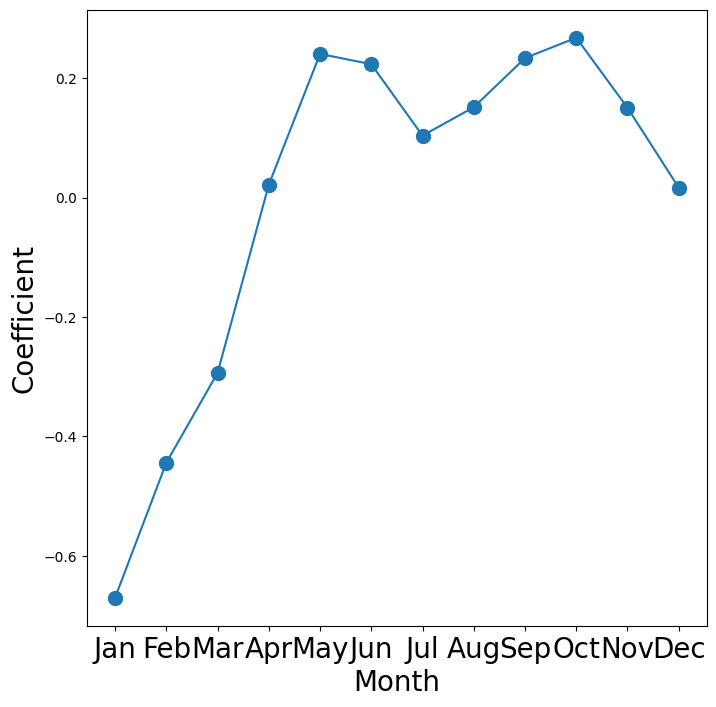

In [163]:
fig_month, ax_month = subplots(figsize=(8, 8))
x_month = np.arange(coeff_mnth.shape[0])
ax_month.plot(x_month, coeff_mnth, marker="o", ms=10)
ax_month.set_xticks(x_month)
ax_month.set_xticklabels([l[5:8] for l in coeff_mnth.index], fontsize=20)
ax_month.set_xlabel("Month", fontsize=20)
ax_month.set_ylabel("Coefficient", fontsize=20)

Text(0, 0.5, 'Coefficient')

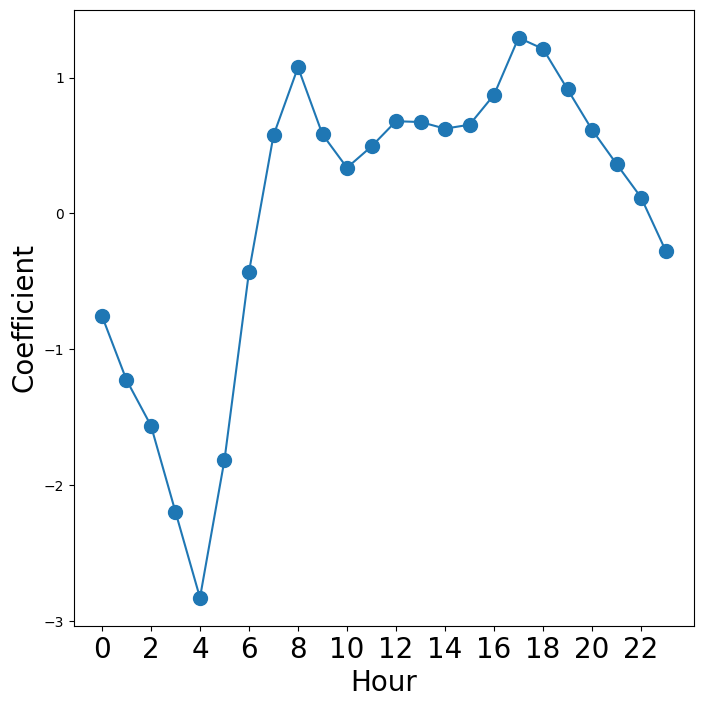

In [164]:
fig_hr, ax_hr = subplots(figsize=(8, 8))
x_hr = np.arange(coeff_hr.shape[0])
ax_hr.plot(x_hr, coeff_hr, marker="o", ms=10)
ax_hr.set_xticks(x_hr[::2])
ax_hr.set_xticklabels(range(24)[::2], fontsize=20)
ax_hr.set_xlabel("Hour", fontsize=20)
ax_hr.set_ylabel("Coefficient", fontsize=20)

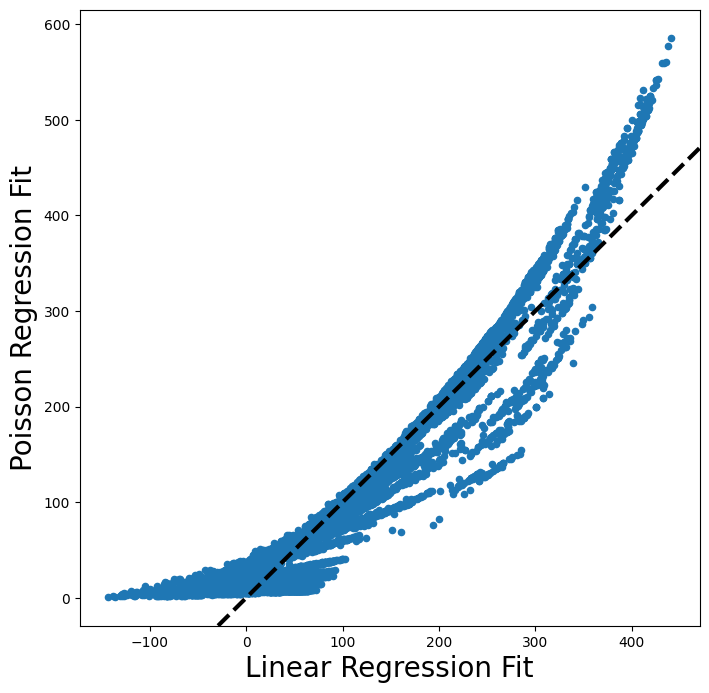

In [166]:
fig, ax = subplots(figsize=(8, 8))
ax.scatter(M2_lm.fittedvalues,
           M_pois.fittedvalues,
           s=20)
ax.set_xlabel("Linear Regression Fit", fontsize=20)
ax.set_ylabel("Poisson Regression Fit", fontsize=20)
ax.axline([0, 0], c="black", linewidth=3, linestyle="--", slope=1)